In [1]:
from mlrl.maze_env import make_maze_env
from mlrl.maze_state import MazeState
from mlrl.search_tree import SearchTree
from mlrl.meta_env import MetaEnv
from mlrl.manhattan_q import ManhattanQHat

object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64)
)
q_hat = ManhattanQHat(object_env)

def make_maze_search_tree(env) -> SearchTree:
    return SearchTree(env, extract_state=MazeState.extract_state)

meta_env = MetaEnv(object_env, q_hat, make_maze_search_tree, max_tree_size=10)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import tensorflow as tf
import tf_agents

In [4]:
num_iterations = 20000

initial_collect_steps = 500 
collect_steps_per_iteration =   1
replay_buffer_max_length = 100000

batch_size = 64 
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 5
eval_interval = 1000

num_actions = meta_env.action_space.n

In [5]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [6]:
env = TFPyEnvironment(GymWrapper(meta_env))

# eval_object_env = make_maze_env(seed=0)
# eval_meta_env = MetaEnv(eval_object_env, q_hat, make_maze_search_tree)
# eval_env = tf_py_environment.TFPyEnvironment(tf_agents.environments.gym_wrapper.GymWrapper(eval_meta_env))

# env.reset()
# eval_env.reset()
eval_env = env

In [7]:
def mask_invalid_action_constraint_splitter(observation):
    return observation['search_tree_tokens'], observation['valid_action_mask']

In [8]:
from mlrl.search_q_model import SearchQModel

In [9]:
x = env.current_time_step().observation['search_tree_tokens']
search_q_model = SearchQModel()
search_q_model(x)

<tf.Tensor: shape=(1, 41), dtype=float32, numpy=
array([[-0.3593185 , -0.18305103, -0.11454794, -0.32204938, -0.1562942 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 , -0.3593185 ,
        -0.3593185 ]], dtype=float32)>

In [11]:
search_q_model.q_network.summary()

Model: "q_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 10, 192)              3648      
                                                                 
 reshape (Reshape)           (1, 40, 48)               0         
                                                                 
 prepend_terminate_token (Pr  (1, 41, 48)              0         
 ependTerminateToken)                                            
                                                                 
 transformer (Transformer)   (1, 41, 48)               11200     
                                                                 
 transformer_1 (Transformer)  (1, 41, 48)              11200     
                                                                 
 dense_1 (Dense)             (1, 41, 1)                49        
                                                         

In [12]:
q_net = sequential.Sequential([SearchQModel()])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter,
    train_step_counter=train_step_counter
)

agent.initialize()

INFO:tensorflow:Assets written to: ram://000bb11a-af43-4653-a063-0bcc963e20d8/assets


INFO:tensorflow:Assets written to: ram://000bb11a-af43-4653-a063-0bcc963e20d8/assets


In [13]:
agent.policy.action(env.current_time_step())

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>, state=(), info=())

In [14]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec(),
                                                observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter)

In [15]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(random_policy, eval_env))

In [16]:
embed_mp4(create_policy_eval_video(agent.policy, eval_env))

In [17]:
def compute_avg_return(environment: tf_agents.environments.TFEnvironment,
                       policy: tf_agents.policies.TFPolicy,
                       num_episodes: int = 3,
                       max_steps: int = 500) -> float:

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        n_steps = 0
        while not time_step.is_last() and n_steps < max_steps:
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            n_steps += 1

        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy().mean()

In [18]:
compute_avg_return(env, random_policy)

-0.35149014

In [19]:
compute_avg_return(env, agent.policy)

-0.6366831

In [20]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)


def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(env, random_policy, replay_buffer, initial_collect_steps)

In [21]:
iter(replay_buffer.as_dataset()).next()

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


(Trajectory(
 {'action': <tf.Tensor: shape=(), dtype=int64, numpy=39>,
  'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  'next_step_type': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  'observation': {'search_tree_tokens': <tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,
          0.   ,  3.   ],
        [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   , -0.004,  1.   ,
          0.   ,  4.   ],
        [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   , -0.004,  1.   ,
          0.   ,  4.   ],
        [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   , -0.004,  1.   ,
          0.   ,  4.   ],
        [ 1.   ,  0.   

In [22]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': {'search_tree_tokens': TensorSpec(shape=(64, 2, 10, 18), dtype=tf.float32, name=None),
                 'valid_action_mask': TensorSpec(shape=(64, 2, 41), dtype=tf.int32, name=None)},
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [23]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_episodes=3, max_steps=)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 0.0002696747542358935
step = 400: loss = 6.116553413448855e-05
step = 600: loss = 1.5205975614662748e-05
step = 800: loss = 9.506326023256406e-06
step = 1000: loss = 8.868966688169166e-06
step = 1000: Average Return = -0.0179277453571558
step = 1200: loss = 6.854730600025505e-06
step = 1400: loss = 1.027946564136073e-05
step = 1600: loss = 1.330215764028253e-05
step = 1800: loss = 1.3270250747154932e-05
step = 2000: loss = 1.632540806895122e-05
step = 2000: Average Return = 0.5872498154640198
step = 2200: loss = 1.0953458513540681e-05
step = 2400: loss = 1.828751919674687e-05
step = 2600: loss = 1.0911086064879782e-05
step = 2800: loss = 2.28122098633321e-05
step = 3000: loss = 1.6733185475459322e-05
step = 3000: Average Return = 0.44924864172935486
step = 3200: loss = 1.6389607480959967e-05
step = 3400: loss = 2.0270428649382666e-05
step = 3600: loss = 0.00015199350309558213
step = 3800: loss = 0.00012539881572593004
step = 4000: loss = 2.6730947865871713e-05
step =

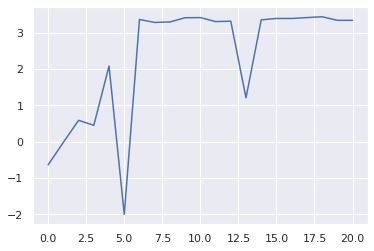

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

plt.plot(list(range(len(returns))), returns);

In [27]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

eval_object_env = make_maze_env(
    seed=1, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64)
)
eval_meta_env = MetaEnv(eval_object_env, q_hat, make_maze_search_tree, max_tree_size=10)
eval_env = TFPyEnvironment(GymWrapper(eval_meta_env))

embed_mp4(create_policy_eval_video(agent.policy, eval_env, max_steps=300))

In [28]:
embed_mp4(create_policy_eval_video(agent.policy, eval_env, max_steps=120))

In [29]:
agent._q_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
search_q_model_1 (SearchQMod multiple                  26097     
Total params: 26,097
Trainable params: 26,097
Non-trainable params: 0
_________________________________________________________________


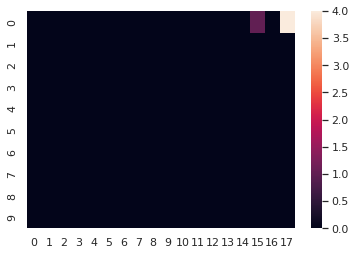

In [34]:
sns.heatmap(env.current_time_step().observation['search_tree_tokens'][0]);

<AxesSubplot:>

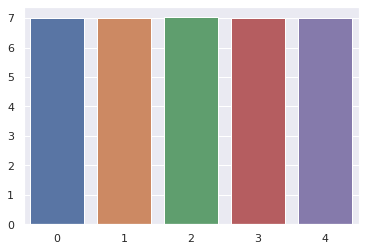

In [43]:
ts = env.current_time_step()
q_vals, *_ = agent._q_network(ts.observation['search_tree_tokens'])
q_vals = q_vals.numpy()[0][ts.observation['valid_action_mask'][0] == 1]

sns.barplot(x=list(range(q_vals.size)), y=q_vals)

In [41]:
q_vals

array([7.0165997, 7.0182085, 7.029525 , 7.0182304, 7.01842  , 7.01645  ,
       7.015478 , 7.016347 , 7.015832 , 7.01645  , 7.015478 , 7.016347 ,
       7.015832 , 7.01645  , 7.015478 , 7.016347 , 7.015832 , 7.01645  ,
       7.015478 , 7.016347 , 7.015832 , 7.01645  , 7.015478 , 7.016347 ,
       7.015832 , 7.01645  , 7.015478 , 7.016347 , 7.015832 , 7.01645  ,
       7.015478 , 7.016347 , 7.015832 , 7.01645  , 7.015478 , 7.016347 ,
       7.015832 , 7.01645  , 7.015478 , 7.016347 , 7.015832 ],
      dtype=float32)

In [45]:
(500 * 2 / 3) * 0.012 - (150 / 3) * 0.004

3.8